[View in Colaboratory](https://colab.research.google.com/github/mingweihe/HandGestureRecognition/blob/master/Hybrid7Init6clsQ.ipynb)

In [0]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
import time
import os

In [0]:
# Set parameters
image_height = 300
image_width = 370
num_channels = 3
num_categories = 6
num_filters1 = 32
num_filters2 = 64
num_filters3 = 64
num_filters4 = 128
num_filters5 = 256
num_filters6 = 512
num_filters7 = 1024
filter_size = 3
num_epochs = 100
batch_size = 10
pooling_size = 2
fully_connected_size = 1024
log_dir = os.path.join('log', 'cnnGesture')
chkp_dir = os.path.join('checkpoints', 'cnnGesture')
chkp_name = 'model'
learning_rate = 5e-4
min_after_dequeue = 1000
capacity=min_after_dequeue+3*batch_size

In [0]:
tf.Variable(num_epochs, name='num_epochs')
tf.Variable(batch_size, name='batch_size')
tf.Variable(log_dir, name='log_dir')

In [0]:
# images plotting function
def plotImg(imgs, titles = None):
    fig = plt.figure()
    for i in range(len(imgs)):
        ax = fig.add_subplot(1, len(imgs), i + 1)
        if titles != None:
            ax.title.set_text(titles[i])
        plt.imshow(imgs[i])
        plt.axis('off')
    plt.show()

In [0]:
trainSetReader=tf.TFRecordReader()
testSetReader=tf.TFRecordReader()
fmt = {'image_raw':tf.FixedLenFeature([],tf.string), 'label':tf.FixedLenFeature([],tf.int64)}
fmt1 = {'size':tf.FixedLenFeature([],tf.int64)}
# read train set graph
train_queue=tf.train.string_input_producer(['Records/train.tfrecords'], num_epochs=num_epochs, shuffle=True, name='train_queue')   
_,serialized_train_set=trainSetReader.read(train_queue)
train_features=tf.parse_single_example(serialized_train_set, features=fmt)
train_images=tf.decode_raw(train_features['image_raw'],tf.uint8)
train_images=tf.reshape(train_images,[image_height,image_width,num_channels])
train_labels=tf.cast(train_features['label'],tf.int32)
train_labels=tf.one_hot(train_labels, num_categories, on_value=1.0, off_value=0.0, dtype=tf.float32)

train_queue1=tf.train.string_input_producer(['Records/train.meta'])
_,serialized_train_set1=trainSetReader.read(train_queue1)
train_features1=tf.parse_single_example(serialized_train_set1, features=fmt1)
train_total=tf.cast(train_features1['size'],tf.int32)

# read test set graph
test_queue=tf.train.string_input_producer(['Records/test.tfrecords'])
_,serialized_test_set=testSetReader.read(test_queue)
test_features=tf.parse_single_example(serialized_test_set,features=fmt)
test_images=tf.decode_raw(test_features['image_raw'],tf.uint8)
test_images=tf.reshape(test_images,[image_height,image_width,num_channels])
test_labels=tf.cast(test_features['label'],tf.int32)
test_labels=tf.one_hot(test_labels, num_categories, on_value=1.0, off_value=0.0, dtype=tf.float32)

test_queue1=tf.train.string_input_producer(['Records/test.meta'])
_,serialized_test_set1=testSetReader.read(test_queue1)
test_features1=tf.parse_single_example(serialized_test_set1,features=fmt1)
test_total=tf.cast(test_features1['size'],tf.int32)

sess=tf.Session()
sess.run(tf.local_variables_initializer())
coord=tf.train.Coordinator()
threads=tf.train.start_queue_runners(sess=sess,coord=coord)
train_total,test_total=sess.run([train_total,test_total])
coord.request_stop()
coord.join(threads)
sess.close()

tf.Variable(train_total, name='train_total')
tf.Variable(test_total, name='test_total')

# batch train set queue graph
train_images_batch,train_label_batch=tf.train.shuffle_batch([train_images,train_labels],batch_size=batch_size,
capacity=capacity,min_after_dequeue=min_after_dequeue, name='batchTrainData')

# total test set queue graph
test_images_batch,test_label_batch=tf.train.shuffle_batch([test_images,test_labels],batch_size=test_total,
capacity=capacity,min_after_dequeue=min_after_dequeue, name='totalTestData')

In [0]:
# Placeholders for images
img_holder = tf.placeholder(tf.float32, [None, image_height, image_width,
num_channels], name = 'img_holder')
lbl_holder = tf.placeholder(tf.int8, [None, num_categories], name = 'lbl_holder')
train = tf.placeholder(tf.bool, name = 'train_bool')

In [0]:
# Preprocess the image, Performs random transformations
# Random flip left and right
img_tensor_flip = tf.map_fn(lambda img: tf.image.random_flip_left_right(img), img_holder)
# Random flip up and down 
img_tensor_flip1 = tf.map_fn(lambda img: tf.image.random_flip_up_down(img), img_tensor_flip)
# Random brightness
img_tensor_bri = tf.map_fn(lambda img: tf.image.random_brightness(img, max_delta=0.2), img_tensor_flip1)
# Per-image scaling
img_tensor_std = tf.map_fn(lambda img: tf.image.per_image_standardization(img), img_tensor_bri)

In [0]:
# Create convolution/pooling layers
conv1 = tf.layers.conv2d(img_tensor_std, num_filters1, filter_size, padding='same', \
activation=tf.nn.relu, name = 'conv1')
print(np.shape(img_tensor_std))
print(np.shape(conv1))

In [0]:
pool1 = tf.layers.max_pooling2d(conv1, pooling_size, pooling_size, name = 'pool1')
print(np.shape(pool1))

In [0]:
conv2 = tf.layers.conv2d(pool1, num_filters2, filter_size, padding='same',
activation=tf.nn.relu, name = 'conv2')

In [0]:
pool2 = tf.layers.max_pooling2d(conv2, pooling_size, pooling_size, name = 'pool2')
print(np.shape(pool2))

In [0]:
conv3 = tf.layers.conv2d(pool2, num_filters3, filter_size, padding='same',
activation=tf.nn.relu, name = 'conv3')

In [0]:
pool3 = tf.layers.max_pooling2d(conv3, pooling_size, pooling_size, name = 'pool3')
print(np.shape(pool3))

In [0]:
conv4 = tf.layers.conv2d(pool3, num_filters4, filter_size, padding='same',
activation=tf.nn.relu, name = 'conv4')

In [0]:
conv5 = tf.layers.conv2d(conv4, num_filters5, filter_size, padding='same',
activation=tf.nn.relu, name = 'conv5')

In [0]:
pool4 = tf.layers.max_pooling2d(conv5, pooling_size, pooling_size, name = 'pool4')
print(np.shape(pool4))

In [0]:
conv6 = tf.layers.conv2d(pool4, num_filters6, filter_size, padding='same',
activation=tf.nn.relu, name = 'conv6')

In [0]:
pool5 = tf.layers.max_pooling2d(conv6, pooling_size, pooling_size, name = 'pool5')
print(np.shape(pool5))

In [0]:
conv7 = tf.layers.conv2d(pool5, num_filters7, filter_size, padding='same',
activation=tf.nn.relu, name = 'conv7')

In [0]:
pool6 = tf.layers.average_pooling2d(conv7, 9, 11, name = 'pool6')
print(np.shape(pool6))

In [0]:
# Flatten input data
flatten = tf.reshape(pool6, [-1, fully_connected_size], name = 'flatten')
print(np.shape(flatten))

In [0]:
# Create connected layers
with tf.contrib.framework.arg_scope(
[tf.contrib.layers.fully_connected],
normalizer_fn=tf.contrib.layers.batch_norm,
normalizer_params={'is_training': train}):
    fc1 = tf.contrib.layers.fully_connected(flatten, fully_connected_size, scope = 'fc1')
    fc2 = tf.contrib.layers.fully_connected(fc1, num_categories,
    activation_fn=None, scope = 'fc2')

In [23]:
# Compute loss
loss = tf.reduce_mean(
tf.nn.softmax_cross_entropy_with_logits(
logits=fc2, labels=lbl_holder), name = 'loss')

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [0]:
# Create optimizer
global_step = tf.Variable(0, name='global_step', trainable=False)
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, name = 'optimizer', global_step = global_step)

In [0]:
# Determine success rate
prediction = tf.argmax(fc2, 1, name = 'prediction')
correct_pred = tf.equal(prediction, tf.argmax(lbl_holder, 1), name = 'correct_pred')
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name = 'accuracy')
# probabilities of each class
probabilities = tf.nn.softmax(fc2, name='probabilities')
# # tensorboard
# summary_loss=tf.summary.scalar('loss', loss)
# summary_accuracy=tf.summary.scalar('accuracy', accuracy)
# merged_op = tf.summary.merge([summary_loss, summary_accuracy])
# # Create FileWriter
# file_writer = tf.summary.FileWriter(log_dir, graph=tf.get_default_graph())

In [0]:
# session and variable initialize
sess=tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())
coord=tf.train.Coordinator()
threads=tf.train.start_queue_runners(sess=sess,coord=coord)
# saver for storing training result
saver = tf.train.Saver()

In [27]:
try:
    test_images,test_labels = sess.run([test_images_batch, test_label_batch])
    batch_i = 1
    total_batch = 0
    local_epoch = 1
    start_time = time.time()
    while not coord.should_stop():
        imgs, labels = sess.run([train_images_batch, train_label_batch])
        sess.run(optimizer, feed_dict={img_holder:imgs,lbl_holder:labels,train: True})
#         # record the summary to the log file
#         summary = sess.run(merged_op, feed_dict={img_holder:imgs,lbl_holder:labels,train: False})
#         file_writer.add_summary(summary)
#         file_writer.flush()
        if batch_i % 10 == 0:
            loss_val, accuracy_val = sess.run([loss, accuracy], feed_dict={img_holder:imgs,lbl_holder:labels,train: False})
            test_accuracy = sess.run(accuracy, feed_dict={img_holder:test_images,lbl_holder:test_labels,train: False})
            duration = time.time() - start_time
            print('epoch:', str(local_epoch)+ '/' +str(num_epochs), 'batch:', batch_i, 'loss:', 
                  loss_val, 'cur_accuracy:', accuracy_val, 'test_accuracy:', test_accuracy, 'duration: %.3fs' % duration)
            start_time = time.time()
        batch_i += 1
        total_batch += batch_size
        if total_batch >= train_total:
            local_epoch += 1
            total_batch = 0
            batch_i = 1
except tf.errors.OutOfRangeError:
    print('Done.')
except Exception as e:
    coord.request_stop(e)
finally:
    coord.request_stop()
coord.join(threads)
# save training result
saver.save(sess, os.path.join(chkp_dir, chkp_name))
sess.close()

epoch: 1/100 batch: 10 loss: 6.441991 cur_accuracy: 0.1 test_accuracy: 0.18897638 duration: 10.933s
epoch: 1/100 batch: 20 loss: 17.298744 cur_accuracy: 0.2 test_accuracy: 0.18897638 duration: 3.141s
epoch: 1/100 batch: 30 loss: 27.608103 cur_accuracy: 0.2 test_accuracy: 0.18897638 duration: 3.149s
epoch: 1/100 batch: 40 loss: 25.73555 cur_accuracy: 0.2 test_accuracy: 0.18897638 duration: 3.125s
epoch: 1/100 batch: 50 loss: 11.364553 cur_accuracy: 0.4 test_accuracy: 0.23228346 duration: 3.150s
epoch: 1/100 batch: 60 loss: 64.63432 cur_accuracy: 0.1 test_accuracy: 0.23228346 duration: 3.164s
epoch: 2/100 batch: 10 loss: 44.84416 cur_accuracy: 0.3 test_accuracy: 0.21259843 duration: 3.794s
epoch: 2/100 batch: 20 loss: 103.08806 cur_accuracy: 0.1 test_accuracy: 0.18897638 duration: 3.155s
epoch: 2/100 batch: 30 loss: 84.05056 cur_accuracy: 0.3 test_accuracy: 0.18897638 duration: 3.176s
epoch: 2/100 batch: 40 loss: 73.21321 cur_accuracy: 0.3 test_accuracy: 0.18897638 duration: 3.168s
epoch

epoch: 8/100 batch: 30 loss: 141.26797 cur_accuracy: 0.1 test_accuracy: 0.23228346 duration: 3.128s
epoch: 8/100 batch: 40 loss: 140.82443 cur_accuracy: 0.1 test_accuracy: 0.18110237 duration: 3.142s
epoch: 8/100 batch: 50 loss: 35.179382 cur_accuracy: 0.2 test_accuracy: 0.18110237 duration: 3.179s
epoch: 8/100 batch: 60 loss: 12.084087 cur_accuracy: 0.3 test_accuracy: 0.18897638 duration: 3.170s
epoch: 9/100 batch: 10 loss: 109.64414 cur_accuracy: 0.1 test_accuracy: 0.23228346 duration: 3.777s
epoch: 9/100 batch: 20 loss: 74.62817 cur_accuracy: 0.4 test_accuracy: 0.23228346 duration: 3.168s
epoch: 9/100 batch: 30 loss: 133.35425 cur_accuracy: 0.0 test_accuracy: 0.0 duration: 3.159s
epoch: 9/100 batch: 40 loss: 120.02571 cur_accuracy: 0.1 test_accuracy: 0.0 duration: 3.159s
epoch: 9/100 batch: 50 loss: 137.85495 cur_accuracy: 0.0 test_accuracy: 0.23228346 duration: 3.186s
epoch: 9/100 batch: 60 loss: 187.04688 cur_accuracy: 0.1 test_accuracy: 0.23228346 duration: 3.159s
epoch: 10/100 b

epoch: 15/100 batch: 60 loss: 143.06674 cur_accuracy: 0.1 test_accuracy: 0.0 duration: 3.147s
epoch: 16/100 batch: 10 loss: 93.71952 cur_accuracy: 0.2 test_accuracy: 0.0 duration: 3.737s
epoch: 16/100 batch: 20 loss: 78.08486 cur_accuracy: 0.1 test_accuracy: 0.0 duration: 3.142s
epoch: 16/100 batch: 30 loss: 9.183229 cur_accuracy: 0.1 test_accuracy: 0.22047244 duration: 3.137s
epoch: 16/100 batch: 40 loss: 82.22813 cur_accuracy: 0.1 test_accuracy: 0.18897638 duration: 3.136s
epoch: 16/100 batch: 50 loss: 114.9749 cur_accuracy: 0.1 test_accuracy: 0.18897638 duration: 3.139s
epoch: 16/100 batch: 60 loss: 167.93503 cur_accuracy: 0.1 test_accuracy: 0.18897638 duration: 3.138s
epoch: 17/100 batch: 10 loss: 120.047775 cur_accuracy: 0.2 test_accuracy: 0.0 duration: 3.749s
epoch: 17/100 batch: 20 loss: 109.63772 cur_accuracy: 0.1 test_accuracy: 0.0 duration: 3.137s
epoch: 17/100 batch: 30 loss: 77.099396 cur_accuracy: 0.0 test_accuracy: 0.0 duration: 3.168s
epoch: 17/100 batch: 40 loss: 49.655

epoch: 23/100 batch: 30 loss: 92.802414 cur_accuracy: 0.2 test_accuracy: 0.24015749 duration: 3.137s
epoch: 23/100 batch: 40 loss: 77.63433 cur_accuracy: 0.1 test_accuracy: 0.24015749 duration: 3.147s
epoch: 23/100 batch: 50 loss: 50.421364 cur_accuracy: 0.3 test_accuracy: 0.24015749 duration: 3.196s
epoch: 23/100 batch: 60 loss: 85.95912 cur_accuracy: 0.0 test_accuracy: 0.24015749 duration: 3.133s
epoch: 24/100 batch: 10 loss: 259.02057 cur_accuracy: 0.2 test_accuracy: 0.24015749 duration: 3.754s
epoch: 24/100 batch: 20 loss: 210.06123 cur_accuracy: 0.3 test_accuracy: 0.18897638 duration: 3.149s
epoch: 24/100 batch: 30 loss: 114.72878 cur_accuracy: 0.2 test_accuracy: 0.18897638 duration: 3.109s
epoch: 24/100 batch: 40 loss: 204.0853 cur_accuracy: 0.2 test_accuracy: 0.06692913 duration: 3.119s
epoch: 24/100 batch: 50 loss: 202.55617 cur_accuracy: 0.4 test_accuracy: 0.0 duration: 3.159s
epoch: 24/100 batch: 60 loss: 249.52432 cur_accuracy: 0.3 test_accuracy: 0.0 duration: 3.171s
epoch: 

epoch: 30/100 batch: 50 loss: 818.9701 cur_accuracy: 0.1 test_accuracy: 0.23228346 duration: 3.118s
epoch: 30/100 batch: 60 loss: 111.196945 cur_accuracy: 0.4 test_accuracy: 0.13385826 duration: 3.121s
epoch: 31/100 batch: 10 loss: 452.87534 cur_accuracy: 0.1 test_accuracy: 0.0 duration: 3.762s
epoch: 31/100 batch: 20 loss: 659.90515 cur_accuracy: 0.4 test_accuracy: 0.0 duration: 3.118s
epoch: 31/100 batch: 30 loss: 243.88257 cur_accuracy: 0.4 test_accuracy: 0.023622047 duration: 3.147s
epoch: 31/100 batch: 40 loss: 509.3853 cur_accuracy: 0.3 test_accuracy: 0.0 duration: 3.150s
epoch: 31/100 batch: 50 loss: 702.2564 cur_accuracy: 0.1 test_accuracy: 0.031496063 duration: 3.148s
epoch: 31/100 batch: 60 loss: 407.6548 cur_accuracy: 0.3 test_accuracy: 0.17716536 duration: 3.143s
epoch: 32/100 batch: 10 loss: 951.3831 cur_accuracy: 0.0 test_accuracy: 0.0 duration: 3.771s
epoch: 32/100 batch: 20 loss: 646.6673 cur_accuracy: 0.2 test_accuracy: 0.0 duration: 3.172s
epoch: 32/100 batch: 30 loss

epoch: 38/100 batch: 10 loss: 636.5428 cur_accuracy: 0.0 test_accuracy: 0.04330709 duration: 3.822s
epoch: 38/100 batch: 20 loss: 323.4676 cur_accuracy: 0.3 test_accuracy: 0.09448819 duration: 3.198s
epoch: 38/100 batch: 30 loss: 210.98804 cur_accuracy: 0.1 test_accuracy: 0.015748031 duration: 3.401s
epoch: 38/100 batch: 40 loss: 196.31174 cur_accuracy: 0.5 test_accuracy: 0.11023622 duration: 3.216s
epoch: 38/100 batch: 50 loss: 210.5332 cur_accuracy: 0.2 test_accuracy: 0.16929133 duration: 3.214s
epoch: 38/100 batch: 60 loss: 254.51506 cur_accuracy: 0.2 test_accuracy: 0.17716536 duration: 3.197s
epoch: 39/100 batch: 10 loss: 262.53134 cur_accuracy: 0.1 test_accuracy: 0.051181104 duration: 3.820s
epoch: 39/100 batch: 20 loss: 345.07657 cur_accuracy: 0.0 test_accuracy: 0.027559055 duration: 3.246s
epoch: 39/100 batch: 30 loss: 164.83116 cur_accuracy: 0.2 test_accuracy: 0.03937008 duration: 3.215s
epoch: 39/100 batch: 40 loss: 115.08317 cur_accuracy: 0.3 test_accuracy: 0.062992126 durati

epoch: 45/100 batch: 30 loss: 88.3073 cur_accuracy: 0.3 test_accuracy: 0.23622048 duration: 3.203s
epoch: 45/100 batch: 40 loss: 348.28824 cur_accuracy: 0.2 test_accuracy: 0.23228346 duration: 3.238s
epoch: 45/100 batch: 50 loss: 314.91898 cur_accuracy: 0.4 test_accuracy: 0.23228346 duration: 3.209s
epoch: 45/100 batch: 60 loss: 451.5244 cur_accuracy: 0.2 test_accuracy: 0.24015749 duration: 3.191s
epoch: 46/100 batch: 10 loss: 70.38023 cur_accuracy: 0.3 test_accuracy: 0.21259843 duration: 3.800s
epoch: 46/100 batch: 20 loss: 201.84059 cur_accuracy: 0.2 test_accuracy: 0.15748031 duration: 3.221s
epoch: 46/100 batch: 30 loss: 88.184074 cur_accuracy: 0.3 test_accuracy: 0.17322835 duration: 3.162s
epoch: 46/100 batch: 40 loss: 120.23789 cur_accuracy: 0.5 test_accuracy: 0.17322835 duration: 3.206s
epoch: 46/100 batch: 50 loss: 130.53256 cur_accuracy: 0.3 test_accuracy: 0.22047244 duration: 3.238s
epoch: 46/100 batch: 60 loss: 161.27603 cur_accuracy: 0.3 test_accuracy: 0.21259843 duration: 3

epoch: 52/100 batch: 50 loss: 152.3431 cur_accuracy: 0.2 test_accuracy: 0.1496063 duration: 3.171s
epoch: 52/100 batch: 60 loss: 57.72343 cur_accuracy: 0.6 test_accuracy: 0.122047246 duration: 3.199s
epoch: 53/100 batch: 10 loss: 132.97371 cur_accuracy: 0.3 test_accuracy: 0.16141732 duration: 3.812s
epoch: 53/100 batch: 20 loss: 44.030243 cur_accuracy: 0.5 test_accuracy: 0.18110237 duration: 3.201s
epoch: 53/100 batch: 30 loss: 198.55876 cur_accuracy: 0.3 test_accuracy: 0.08267716 duration: 3.216s
epoch: 53/100 batch: 40 loss: 329.3117 cur_accuracy: 0.2 test_accuracy: 0.08661418 duration: 3.204s
epoch: 53/100 batch: 50 loss: 137.21591 cur_accuracy: 0.5 test_accuracy: 0.24409449 duration: 3.208s
epoch: 53/100 batch: 60 loss: 622.302 cur_accuracy: 0.4 test_accuracy: 0.22440945 duration: 3.181s
epoch: 54/100 batch: 10 loss: 356.50995 cur_accuracy: 0.1 test_accuracy: 0.21259843 duration: 3.776s
epoch: 54/100 batch: 20 loss: 285.61163 cur_accuracy: 0.1 test_accuracy: 0.22047244 duration: 3.

epoch: 60/100 batch: 10 loss: 117.492714 cur_accuracy: 0.3 test_accuracy: 0.18897638 duration: 3.828s
epoch: 60/100 batch: 20 loss: 199.5331 cur_accuracy: 0.4 test_accuracy: 0.20866142 duration: 3.204s
epoch: 60/100 batch: 30 loss: 74.902176 cur_accuracy: 0.4 test_accuracy: 0.17716536 duration: 3.215s
epoch: 60/100 batch: 40 loss: 55.916363 cur_accuracy: 0.3 test_accuracy: 0.2519685 duration: 3.205s
epoch: 60/100 batch: 50 loss: 18.405474 cur_accuracy: 0.7 test_accuracy: 0.27165353 duration: 3.233s
epoch: 60/100 batch: 60 loss: 104.17488 cur_accuracy: 0.1 test_accuracy: 0.22047244 duration: 3.184s
epoch: 61/100 batch: 10 loss: 35.11544 cur_accuracy: 0.5 test_accuracy: 0.23622048 duration: 3.790s
epoch: 61/100 batch: 20 loss: 92.92961 cur_accuracy: 0.2 test_accuracy: 0.16929133 duration: 3.225s
epoch: 61/100 batch: 30 loss: 183.14157 cur_accuracy: 0.3 test_accuracy: 0.16929133 duration: 3.215s
epoch: 61/100 batch: 40 loss: 297.13846 cur_accuracy: 0.0 test_accuracy: 0.16929133 duration: 

epoch: 67/100 batch: 30 loss: 119.839294 cur_accuracy: 0.3 test_accuracy: 0.24409449 duration: 3.239s
epoch: 67/100 batch: 40 loss: 186.57315 cur_accuracy: 0.2 test_accuracy: 0.2480315 duration: 3.202s
epoch: 67/100 batch: 50 loss: 144.11203 cur_accuracy: 0.3 test_accuracy: 0.2519685 duration: 3.234s
epoch: 67/100 batch: 60 loss: 130.07039 cur_accuracy: 0.3 test_accuracy: 0.22834645 duration: 3.181s
epoch: 68/100 batch: 10 loss: 180.64056 cur_accuracy: 0.2 test_accuracy: 0.22834645 duration: 3.801s
epoch: 68/100 batch: 20 loss: 150.25731 cur_accuracy: 0.2 test_accuracy: 0.24409449 duration: 3.180s
epoch: 68/100 batch: 30 loss: 75.12168 cur_accuracy: 0.3 test_accuracy: 0.34251967 duration: 3.192s
epoch: 68/100 batch: 40 loss: 101.99341 cur_accuracy: 0.2 test_accuracy: 0.2992126 duration: 3.164s
epoch: 68/100 batch: 50 loss: 188.04185 cur_accuracy: 0.3 test_accuracy: 0.24015749 duration: 3.163s
epoch: 68/100 batch: 60 loss: 352.92438 cur_accuracy: 0.2 test_accuracy: 0.2480315 duration: 3

epoch: 74/100 batch: 50 loss: 149.65738 cur_accuracy: 0.1 test_accuracy: 0.22440945 duration: 3.199s
epoch: 74/100 batch: 60 loss: 90.43384 cur_accuracy: 0.4 test_accuracy: 0.23622048 duration: 3.190s
epoch: 75/100 batch: 10 loss: 87.738365 cur_accuracy: 0.1 test_accuracy: 0.16929133 duration: 3.774s
epoch: 75/100 batch: 20 loss: 72.90897 cur_accuracy: 0.5 test_accuracy: 0.16141732 duration: 3.218s
epoch: 75/100 batch: 30 loss: 209.69087 cur_accuracy: 0.2 test_accuracy: 0.1496063 duration: 3.195s
epoch: 75/100 batch: 40 loss: 57.02003 cur_accuracy: 0.4 test_accuracy: 0.15354331 duration: 3.210s
epoch: 75/100 batch: 50 loss: 84.62518 cur_accuracy: 0.3 test_accuracy: 0.22047244 duration: 3.207s
epoch: 75/100 batch: 60 loss: 106.16958 cur_accuracy: 0.1 test_accuracy: 0.26377952 duration: 3.206s
epoch: 76/100 batch: 10 loss: 66.84199 cur_accuracy: 0.4 test_accuracy: 0.3464567 duration: 3.824s
epoch: 76/100 batch: 20 loss: 37.960716 cur_accuracy: 0.3 test_accuracy: 0.31496063 duration: 3.18

epoch: 82/100 batch: 10 loss: 188.25876 cur_accuracy: 0.2 test_accuracy: 0.23622048 duration: 3.794s
epoch: 82/100 batch: 20 loss: 47.3853 cur_accuracy: 0.3 test_accuracy: 0.3464567 duration: 3.201s
epoch: 82/100 batch: 30 loss: 35.329494 cur_accuracy: 0.1 test_accuracy: 0.33858266 duration: 3.223s
epoch: 82/100 batch: 40 loss: 75.26611 cur_accuracy: 0.0 test_accuracy: 0.27165353 duration: 3.168s
epoch: 82/100 batch: 50 loss: 23.377579 cur_accuracy: 0.5 test_accuracy: 0.35433072 duration: 3.199s
epoch: 82/100 batch: 60 loss: 30.495478 cur_accuracy: 0.4 test_accuracy: 0.33858266 duration: 3.190s
epoch: 83/100 batch: 10 loss: 49.81167 cur_accuracy: 0.1 test_accuracy: 0.20472442 duration: 3.828s
epoch: 83/100 batch: 20 loss: 8.330151 cur_accuracy: 0.7 test_accuracy: 0.2992126 duration: 3.208s
epoch: 83/100 batch: 30 loss: 29.356823 cur_accuracy: 0.1 test_accuracy: 0.25984251 duration: 3.196s
epoch: 83/100 batch: 40 loss: 51.34912 cur_accuracy: 0.3 test_accuracy: 0.20472442 duration: 3.193

epoch: 89/100 batch: 30 loss: 31.932312 cur_accuracy: 0.3 test_accuracy: 0.27165353 duration: 3.198s
epoch: 89/100 batch: 40 loss: 18.869473 cur_accuracy: 0.5 test_accuracy: 0.4566929 duration: 3.167s
epoch: 89/100 batch: 50 loss: 77.50246 cur_accuracy: 0.1 test_accuracy: 0.33464566 duration: 3.205s
epoch: 89/100 batch: 60 loss: 4.5757165 cur_accuracy: 0.7 test_accuracy: 0.38582677 duration: 3.208s
epoch: 90/100 batch: 10 loss: 4.4334574 cur_accuracy: 0.8 test_accuracy: 0.28346458 duration: 3.783s
epoch: 90/100 batch: 20 loss: 11.378365 cur_accuracy: 0.4 test_accuracy: 0.26771653 duration: 3.187s
epoch: 90/100 batch: 30 loss: 23.522457 cur_accuracy: 0.3 test_accuracy: 0.25984251 duration: 3.188s
epoch: 90/100 batch: 40 loss: 23.836437 cur_accuracy: 0.5 test_accuracy: 0.35826772 duration: 3.140s
epoch: 90/100 batch: 50 loss: 17.78371 cur_accuracy: 0.4 test_accuracy: 0.35433072 duration: 3.221s
epoch: 90/100 batch: 60 loss: 5.3328953 cur_accuracy: 0.5 test_accuracy: 0.2992126 duration: 3

epoch: 96/100 batch: 50 loss: 69.78088 cur_accuracy: 0.2 test_accuracy: 0.26771653 duration: 3.161s
epoch: 96/100 batch: 60 loss: 7.7269754 cur_accuracy: 0.4 test_accuracy: 0.2480315 duration: 3.151s
epoch: 97/100 batch: 10 loss: 17.862232 cur_accuracy: 0.5 test_accuracy: 0.31889763 duration: 3.772s
epoch: 97/100 batch: 20 loss: 28.166742 cur_accuracy: 0.3 test_accuracy: 0.31496063 duration: 3.180s
epoch: 97/100 batch: 30 loss: 13.988126 cur_accuracy: 0.3 test_accuracy: 0.24015749 duration: 3.175s
epoch: 97/100 batch: 40 loss: 26.440622 cur_accuracy: 0.3 test_accuracy: 0.3503937 duration: 3.163s
epoch: 97/100 batch: 50 loss: 14.847799 cur_accuracy: 0.6 test_accuracy: 0.32677165 duration: 3.157s
epoch: 97/100 batch: 60 loss: 24.662603 cur_accuracy: 0.4 test_accuracy: 0.31889763 duration: 3.162s
epoch: 98/100 batch: 10 loss: 13.2462635 cur_accuracy: 0.4 test_accuracy: 0.33464566 duration: 3.792s
epoch: 98/100 batch: 20 loss: 12.327204 cur_accuracy: 0.6 test_accuracy: 0.41338584 duration:

In [28]:
# restore checkpoint
sessRes = tf.Session()
saver = tf.train.import_meta_graph(os.path.join(chkp_dir, 'model.meta'))
saver.restore(sessRes, tf.train.latest_checkpoint(chkp_dir))

INFO:tensorflow:Restoring parameters from checkpoints/cnnGesture/model


In [0]:
# test data prediction randomly
img_holder = sessRes.graph.get_tensor_by_name('img_holder:0')
lbl_holder =sessRes.graph.get_tensor_by_name('lbl_holder:0')
predict=tf.get_default_graph().get_tensor_by_name('prediction:0')
accuracy=tf.get_default_graph().get_tensor_by_name('accuracy:0')
train = sessRes.graph.get_tensor_by_name('train_bool:0')
test_total = sessRes.run('test_total:0')

In [30]:
# session to exexute queuing
# restore checkpoint
sess4Q = tf.Session()
saver4Q = tf.train.import_meta_graph(os.path.join(chkp_dir, 'model.meta'))
saver4Q.restore(sess4Q, tf.train.latest_checkpoint(chkp_dir))
sess4Q.run(tf.global_variables_initializer())
sess4Q.run(tf.local_variables_initializer())
coord=tf.train.Coordinator()
threads=tf.train.start_queue_runners(sess=sess4Q,coord=coord)
# batchTrainData = sess4Q.graph.get_tensor_by_name('batchTrainData:0')
# batchTrainLabel = sess4Q.graph.get_tensor_by_name('batchTrainData:1')
totalTestData = sess4Q.graph.get_tensor_by_name('totalTestData:0')
totalTestLabel = sess4Q.graph.get_tensor_by_name('totalTestData:1')
images,labels = sess4Q.run([totalTestData,totalTestLabel])
# reason stop here is we use queue to get test set within one time 'coz we are only tesing training result here. 
coord.request_stop()
coord.join(threads)
sess4Q.close()

INFO:tensorflow:Restoring parameters from checkpoints/cnnGesture/model


169 179


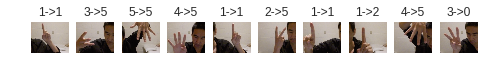

Accuracy: 0.4


In [31]:
begin = random.randrange(0, test_total-10)
end = begin + 10
print(begin, end)
res, accuracy_val = sessRes.run([predict, accuracy], feed_dict = {img_holder: images[begin:end], lbl_holder:labels[begin:end], train: False})
titles = [str(np.argmax(labels[i])) + '->' + str(res[i-begin]) for i in range(begin, end)] 
plotImg(images[begin:end], titles)
print('Accuracy:', accuracy_val)

In [0]:
sessRes.close()

In [0]:
# # memory footprint support libraries/code
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil
# !pip install psutil
# !pip install humanize
# import psutil
# import humanize
# import os
# import GPUtil as GPU
# GPUs = GPU.getGPUs()
# # XXX: only one GPU on Colab and isn’t guaranteed
# gpu = GPUs[0]
# def printm():
#  process = psutil.Process(os.getpid())
#  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " I Proc size: " + humanize.naturalsize( process.memory_info().rss))
#  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
# printm()

In [34]:
#------------------------------------------------
#    Replace google drive trained model with new one
#------------------------------------------------
!rm -rf Hybrid7.zip
!zip -r Hybrid7.zip checkpoints
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_list = drive.ListFile(
    {'q': "'19lVhhib3mhWMW_eQsFFoOQLVsmfN6SB3' in parents"}).GetList()

for f in file_list:
  # delete old one
  fname = f['title']
  print('Deleting', fname)
  f.Delete()
file_metadata = {'title': 'Hybrid7.zip', "parents": [{"id": '19lVhhib3mhWMW_eQsFFoOQLVsmfN6SB3', "kind": "drive#childList"}]}
# Create & upload a file.
uploaded = drive.CreateFile(file_metadata)
uploaded.SetContentFile('Hybrid7.zip')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

  adding: checkpoints/ (stored 0%)
  adding: checkpoints/cnnGesture/ (stored 0%)
  adding: checkpoints/cnnGesture/model.data-00000-of-00001 (deflated 13%)
  adding: checkpoints/cnnGesture/model.index (deflated 50%)
  adding: checkpoints/cnnGesture/model.meta (deflated 88%)
  adding: checkpoints/cnnGesture/checkpoint (deflated 39%)
Deleting Hybrid7.zip
Uploaded file with ID 1u_eTtZFXHHjksinXAwCtoXtPvJKwSqbt


In [35]:
ls Records/ -l

total 289488
-rw-r--r-- 1 root root        34 Jul  2 22:44 test.meta
-rw-r--r-- 1 root root  84598002 Jul  2 22:44 test.tfrecords
-rw-r--r-- 1 root root        34 Jul  2 22:44 train.meta
-rw-r--r-- 1 root root 211828068 Jul  2 22:44 train.tfrecords
